# 3.3.1. Batched training with torch (tg.common.ml.batched_training.torch)

## Overview

`tg.common.ml.batched_training` is very generic and flexible, allowing to orchestrate the training process by using settings and component classes. It greatly reduces the amount of code that needs to be written to train one model, and does not limit the technology stack for the models themselves. 

Unfortunately, there is still _a lot_ of code that needs to be written to instantiate the training task, namely, the `ModelHandler`: the way we have written it in the demo, any small change in network architecture requires the code update. We strongly prefer parameter-based model's definition over code based, as:

  * It's easier to compare and reproduce the results of the experiments
  * It's testable and reusable

Therefore, we wanted to enable a parameter-based definition at least for some models, choosing `PyTorch`:
  * `optimizer` and `loss` in this case do not require coding, as the type names may be used
  * networks creation does not necesserily require coding and can be replaced by _factories_.

Also, we have noticed that some elements of the functionality is not really required in practice:
  * instead of defining splitters, it's more practical to put the values directly in the `index_frame`, thus ensuring all the networks versions are going to be compared over the same sets
  * `BatchingStrategy` can simply be defined by the presence of `priority` column in the `index_frame` (either defined in bundle preparation or in `late_initialization`)
  
  
In essense, what remains really important for the training of `torch` networks, is a pair of two factories:
  * the first one produce the extractors, given the bundle; it also performs necessary bundle tuning. It does requires coding, if the extractors are dependent on the bundle, which is usually not the case, or if tuning is needed.
  * the second one produce the networks, given the batch. It requires coding, if the network is build from predefined blocks.
  
This functionality is implemented in a slim wrapper around `BatchedTrainingTask`, namely, `TorchTrainingTask`. This demonstration will show how to use it. First, let us load the bundle and define the `train`, `display` and `test` splits.

In [1]:
from tg.common.ml import batched_training as bt
from sklearn.model_selection import train_test_split
import numpy as np

bundle = bt.DataBundle.load('temp/bundle')

train, test = train_test_split(bundle.index.index, stratify=bundle.index['Survived'], test_size=0.2)
train, display = train_test_split(train, stratify = bundle.index.loc[train]['Survived'], test_size=0.2)
bundle.index['split'] = np.where(
    bundle.index.index.isin(train),
    'train',
    np.where(
        bundle.index.index.isin(display),
        'display',
        'test'
    ))
bundle.index.groupby(['split','Survived']).size()

split    Survived
display  0.0          88
         1.0          55
test     0.0         110
         1.0          69
train    0.0         351
         1.0         218
dtype: int64

Second, let's remember the extractors we have defined in the previous demo, and define the extractor factory:

In [2]:
from tg.common.ml import dft
from tg.common.ml.batched_training import torch as btt

tfac = dft.DataFrameTransformerFactory.default_factory

extractors = [
    bt.PlainExtractor.build(name='label').apply(take_columns='Survived'),
    bt.PlainExtractor.build(name='cabin').index().apply(transformer=tfac(), take_columns='Cabin'),
    bt.PlainExtractor.build('passengers')
                       .index()
                       .join(frame_name='passengers', on_columns='Name')
                       .apply(transformer=tfac()),
    bt.PlainExtractor.build(name='tickets')
                    .index()
                    .join(frame_name='tickets', on_columns='Ticket')
                    .apply(transformer=tfac())
]

extractor_factory = btt.PredefinedExtractorFactory(*extractors)

As a third step, we will define a network factory:

In [3]:
network_factory = (btt.FullyConnectedNetwork.Factory(sizes = [10,1])
                   .prepend_extraction(input_frames = ['tickets', 'passengers', 'cabin']))


We will explain the architecture behind this definition a bit later. For now, let's define and run `TorchTrainingTask`:

<AxesSubplot:xlabel='iteration'>

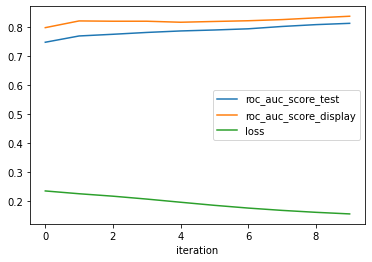

In [4]:
from sklearn.metrics import roc_auc_score
from tg.common import Logger
import pandas as pd

task = btt.TorchTrainingTask(
    bt.TrainingSettings(
        epoch_count=10,
        batch_size=50
    ),
    btt.TorchTrainingSettings(
        optimizer_ctor = btt.OptimizerConstructor('torch.optim:SGD',lr=0.5),
        loss_ctor = btt.ModelConstructor('torch.nn:MSELoss')
    ),
    extractor_factory,
    network_factory,
    bt.MetricPool().add_sklearn(roc_auc_score)
)

Logger.disable()


result = task.run(bundle)

pd.DataFrame(result['output']['history']).set_index('iteration').plot()

We can see that definition of `TorchTrainingTask` is indeed performed with only existing components and does not require much coding.

## Network factories

Network factories are currently more like proof of concept than a comprehensive set of all possible architectures. Still, we find the concept useful. The features are:

* Networks accept batches instead of tensors
* Networks adopt to the batches by choosing the input size so that it matches

This is achieved with the following architecture:

* We have "normal" networks, like `FeedForwardNetwork` or `LSTMNetwork`. These are normal `torch` modules that can be used "as is". 
* Each of such classes, however, has a nested `Factory` class, that is the factory creating the network from the input batch. The input batch is expected to be a torch tensor.
* There are also ways to organize networks (and factories) into structures, for instance, `FeedForwardNetwork` is a network that accepts several networks and pass the signal sequencially. Correspondindly, `FeedForwardNetwork.Factory` accepts several factories, creates instances for them, and in the end -- the instance for `FeedForwardNetwork`.
* For convienience, `FeedForwardNetwork.Factory` has `prepend_extraction` methodm that returns a `FeedForwardNetwork.Factory` with two nested factories: `ExtractingNetwork.Factory` and `FeedForwardNetwork.Factory`. Here `ExtractingNetwork.Factory` create a fake network, that accepts batch, translates the frames into `torch` tensors and concatenates them.